In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import tree

### 실습 과제 1. 데이터 불러온 후 종속변수 데이터 타입 변경, train_data : test_data = 8:2 split, random_state=1000
#### 종속변수는 'class', 독립변수는 나머지 변수

In [51]:
df = pd.read_csv('/home/piai/PycharmProjects/big_data_lecture/data/Hepatitis.csv')

In [52]:
# 1이 걸린거 2가 안걸린거
df['class'] = df['class'].apply(lambda x: 'P' if x == 1 else 'N')

In [53]:
from sklearn.model_selection import train_test_split

X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

### 실습2: 5-fold cross validation을 이용해 최적의 하이퍼파라미터를 구하고, test set에 대한 최적 모델의 예측 정확도 구하기
####  하이퍼 파라미터 : max_depth:[2,4,6], min_samples_split: [2,3,4]

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


model = DecisionTreeClassifier()
params = {'max_depth': [2, 4, 6], 'min_samples_split': [2, 3, 4]}
grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy', return_train_score=True)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6],
                         'min_samples_split': [2, 3, 4]},
             return_train_score=True, scoring='accuracy')

In [55]:
best_model = grid_cv.best_estimator_
y_pred = best_model.predict(X_test)
best_accuracy = metrics.accuracy_score(y_test, y_pred)
print("best accuracy: ", best_accuracy)

best accuracy:  0.875


### 실습 3: 최적 트리 모델 이미지 출력하기 (이미지에 변수 이름과 class가 모두 있어야 함), feature importance barplot 출력

In [56]:
feature_importance_values = best_model.feature_importances_
feature_importance_values = pd.Series(feature_importance_values, index=X_train.columns)

In [57]:
feature_importance_sort=feature_importance_values.sort_values(ascending=False)

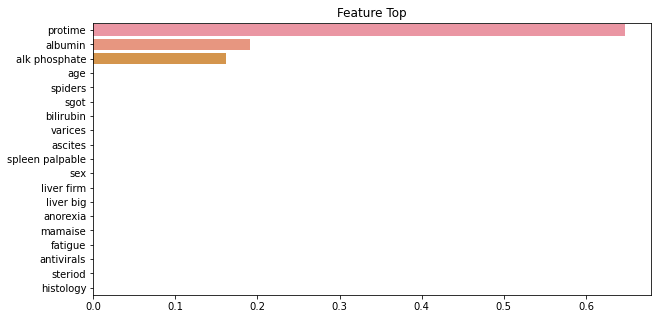

In [58]:
import seaborn as sns

plt.figure(figsize=(10,5))
plt.title("Feature Top")
sns.barplot(x=feature_importance_sort, y=feature_importance_sort.index)
plt.show()

### 실습 4: 최적 트리 모델을 post-pruning하고, post-pruning된 트리 모델 출력(이미지에 변수 이름과 class가 모두 있어야 함)
#### (test accuracy가 높으면서, node개수와 tree depth가 작은 alpha를 찾고, 해당 alpha에 해당하는 트리 모델 출력하는 실습 )

In [59]:
path = best_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

<function matplotlib.pyplot.show(close=None, block=None)>

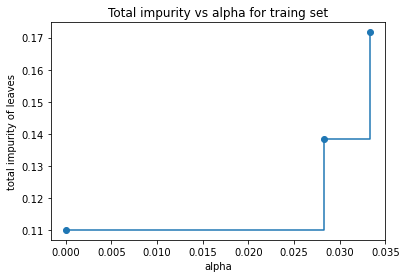

In [60]:
fig, ax = plt.subplots()

ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total impurity vs alpha for traing set")
plt.show

In [61]:
dtree_list = []
for ccp_alpha in ccp_alphas:
    dtree_alpha = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    dtree_alpha.fit(X_train, y_train)
    dtree_list.append(dtree_alpha)

In [62]:
node_counts = [dtree_alpha.tree_.node_count for tree_alpha in dtree_list]
depth = [tree_alpha.tree_.max_depth for tree_alpha in dtree_list]

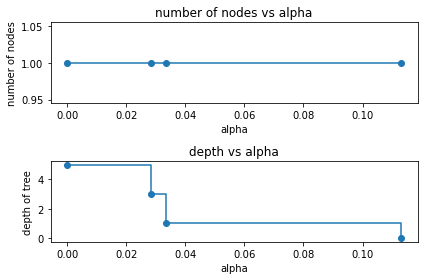

In [63]:
fig, ax = plt.subplots(nrows=2, ncols=1)

ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle='steps-post')
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("number of nodes vs alpha")

ax[1].plot(ccp_alphas, depth, marker='o', drawstyle='steps-post')
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("depth vs alpha")

fig.tight_layout()
plt.show()

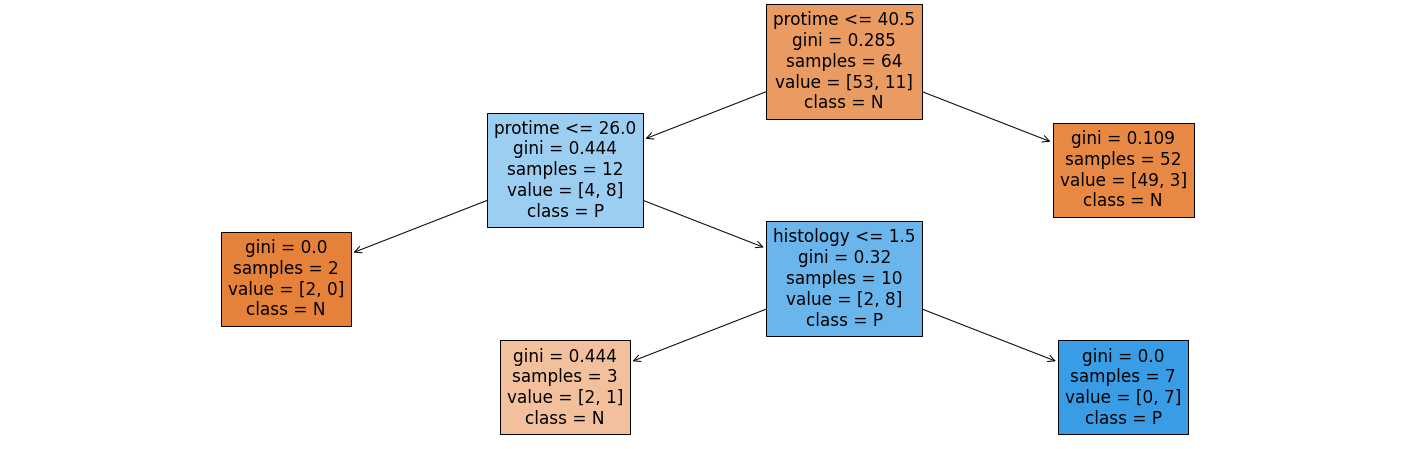

In [64]:
var_names = X_train.columns
class_names = dtree_list[1].classes_

plt.figure(figsize=(25,8))
tree.plot_tree(dtree_list[1],
               feature_names=var_names,
               class_names=class_names,
               filled=True)
plt.show()